In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import math
import cv2
%matplotlib inline

#data_dir = os.path.join(os.getcwd(), 'data', 'whale')
#full_img_dir = os.path.join(os.getcwd(), 'data', 'whale', 'imgs')
cwd = os.getcwd()
output_dir = os.path.join(os.getcwd(), 'for_bb')
input_dir  = os.path.join(os.getcwd(), 'imgs_subset')
TARGET_WIDTH = 300
TARGET_HEIGHT = 300

Using Theano backend.


In [2]:
% cd $input_dir

/home/ryanryanadmin/Documents/ds/whale_recognition/imgs_subset


In [3]:
g = glob('*.jpg')

In [4]:
g[:5]

['w_281.jpg', 'w_224.jpg', 'w_116.jpg', 'w_99.jpg', 'w_0.jpg']

In [5]:
ann = pd.read_csv(os.path.join(cwd, 'bonnet_and_bbox.csv'))

In [6]:
ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2
0,w_7812.jpg,whale_48813,505.953358,505.953358,3072,2048,1411.343576,985.277591,w_7812.jpg,1668.211366,1370.097707,1647.792622,1108.737787
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114
2,w_3828.jpg,whale_45062,459.951546,600.753039,3072,2048,1060.704585,826.035429,w_3828.jpg,1118.947159,908.634098,1345.595214,963.764706
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982


In [7]:
subset = ann[ann.Image.isin(g)]

In [8]:
def find_new_bb(r, target_width, target_height):
    #print(r) 
    width_ratio = target_width / r.image_width
    height_ratio = target_height / r.image_height 
    bboxx_new = width_ratio * r.bboxx

    
    bboxy_new = height_ratio * r.bboxy
    
    width_final = width_ratio * r.width
    height_final = height_ratio * r.height
    
    
    return [r.Image,bboxx_new, bboxy_new, width_final, height_final]

In [9]:
def crop_new_bb(r, target_width, target_height):
    #print(r)
    y_start = int(r.bboxy)
    x_start = int(r.bboxx)
    y_crop = int(r.bboxy + r.height)
    x_crop = int(r.bboxx + r.width) 
    
    x1_crop = r.x_1 - x_start
    x2_crop = r.x_2 - x_start
    x1_final = (target_width / r.width) * x1_crop
    x2_final = (target_width / r.width) * x2_crop


    y1_crop = r.y_1 - y_start
    y2_crop = r.y_2 - y_start
    y1_final = (target_height / r.height) * y1_crop
    y2_final = (target_height / r.height) * y2_crop
    
    return [r.Image, x1_final, x2_final, y1_final, y2_final]

In [10]:

t = subset.apply(lambda r: find_new_bb(r, TARGET_WIDTH, TARGET_HEIGHT), axis=1)

In [11]:
t = np.array([np.array(l) for l in t.values])

In [12]:
t = pd.DataFrame(t, columns=['Image','bboxx_new', 'bboxy_new', 'width_new', 'height_new'])

In [13]:
subset = subset.merge(t, on ='Image', )

In [14]:
subset.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
0,w_446.jpg,whale_68116,479.229804,495.754970,3072,2048,1135.514954,797.929427,w_446.jpg,1241.459621,1110.779661,1396.642074,894.340977,110.89013223730468,116.88419343896484,48.413571246875,70.1996783080078
1,w_133.jpg,whale_64006,539.739059,497.498611,3072,2048,1309.453890,718.087617,w_133.jpg,1649.834497,1149.575274,1545.698903,908.634098,127.87635646582032,105.18861580268555,48.583848693164065,79.06333867529297
2,w_112.jpg,whale_40169,412.073487,392.450940,3072,2048,1412.823384,840.966300,w_112.jpg,1584.494516,908.634098,1559.992024,988.267198,137.97103359375,123.1884228515625,38.325287109375,60.36232719726563
3,w_353.jpg,whale_28263,818.845565,762.258677,3072,2048,1145.052335,589.169370,w_353.jpg,1651.876371,1298.632104,1553.866401,922.927218,111.82151713183595,86.30410697197264,74.43932390429687,119.94808087631836
4,w_354.jpg,whale_34656,487.775239,385.004984,3072,2048,1852.932354,949.474443,w_354.jpg,2133.758724,1268.003988,1911.194417,1086.277168,180.95042524316406,139.08317039575195,37.598142993359374,71.45145102729492


In [15]:
def crop(r, target_width, target_height, input_dir, output_dir):    
    r = r[1]
    f_name = os.path.join(input_dir, r.Image)
    img = Image.open(f_name)
    img = img.resize((target_width, target_height))
    img.save(os.path.join(output_dir, r.Image))



In [17]:
for r in subset.iterrows():
    crop(r, TARGET_WIDTH, TARGET_HEIGHT, input_dir, output_dir)

# Check

In [18]:
def check(r, target_width, target_height, input_dir):    
    r = r[1]
    f_name = os.path.join(input_dir, r.Image)
    img = Image.open(f_name)
    #img = img.resize((target_width, target_height))
    img_arr = np.array(img, dtype=np.uint8)
    
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
     # Create a Rectangle patch
     
    rect = patches.Rectangle((r.bboxx_new ,r.bboxy_new),
                             r.width_new,
                             r.height_new, 
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')
    ax.add_patch(rect)

    plt.show()


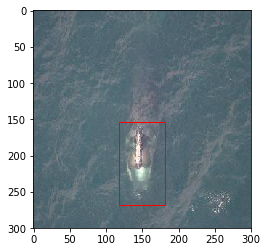

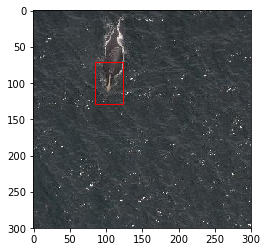

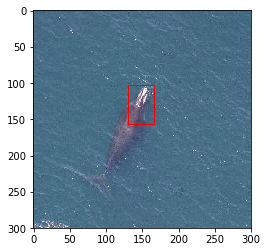

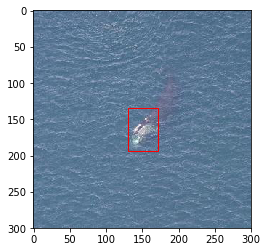

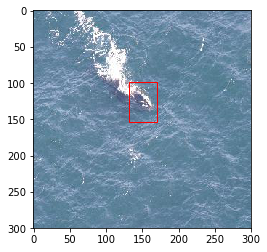

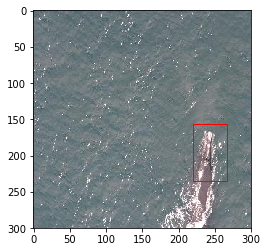

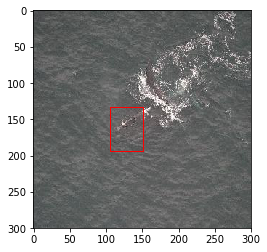

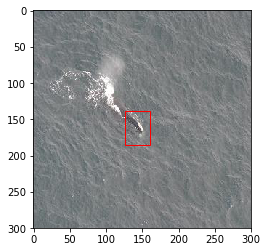

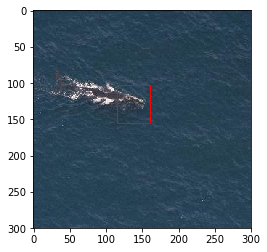

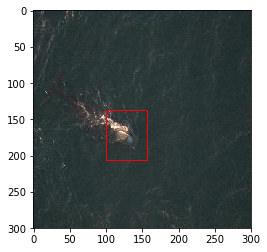

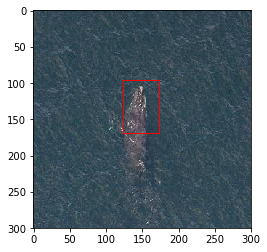

In [19]:
samp = subset.sample(frac=0.05)

for r in samp.iterrows():
    check(r, TARGET_WIDTH, TARGET_HEIGHT, output_dir)